In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import gc

# Constants (from your original code)
SEQUENCE_LENGTH = 25000
NUM_CLASSES = 4
CLASS_NAMES = ["Bike Trotting", "Jack Hammering", "Jumping", "Walking"]
DOWNSAMPLE_FACTOR = 5  # Same as what you used in training
BATCH_SIZE = 32  # Larger batch size for faster prediction

# Path to your saved model
MODEL_PATH = "/content/drive/MyDrive/das_model_results_20250301_174725/best_model.keras"

# Path to your data file containing 80k rows
X_LARGE_DATA_PATH = "/content/drive/MyDrive/final_dataset.npy"  # Your actual data file
Y_LARGE_DATA_PATH = "/content/drive/MyDrive/final_labels.npy"  # Your actual labels file

# Output directory for results
OUTPUT_DIR = "/content/drive/MyDrive/das_prediction_results_80k"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def check_data_format(data_path, labels_path=None):
    """Check the format of input data and labels"""
    print(f"Checking data format from {data_path}")

    # Load just a small sample for checking
    try:
        data_sample = np.load(data_path, mmap_mode='r')
        print(f"Data shape: {data_sample.shape}")
        print(f"Data type: {data_sample.dtype}")

        # Check the first item dimension
        if len(data_sample.shape) >= 2:
            print(f"First item shape: {data_sample[0].shape}")

        if labels_path and os.path.exists(labels_path):
            labels_sample = np.load(labels_path, mmap_mode='r')
            print(f"Labels shape: {labels_sample.shape}")
            print(f"Labels type: {labels_sample.dtype}")

            # Check labels format
            if len(labels_sample.shape) == 1:
                print("Labels are in integer format (not one-hot encoded)")
                # Show distribution of classes
                unique_values, counts = np.unique(labels_sample, return_counts=True)
                print("Label distribution:")
                for val, count in zip(unique_values, counts):
                    print(f"  Class {val}: {count} samples")
            else:
                print("Labels appear to be one-hot encoded")

        return data_sample.shape, labels_path and os.path.exists(labels_path)

    except Exception as e:
        print(f"Error checking data format: {e}")
        return None, False

def load_and_process_data_in_batches(data_path, labels_path=None, batch_size=100, downsample_factor=5,
                                     max_rows=80000, has_labels=True):
    """
    Load and process large data in batches to avoid memory issues
    """
    print(f"Loading data from {data_path}")

    # Get file size for memory mapping
    file_info = os.stat(data_path)
    file_size = file_info.st_size

    # Load the data shape without loading all data
    data_mmap = np.load(data_path, mmap_mode='r')
    total_rows = min(data_mmap.shape[0], max_rows)
    print(f"Total rows in file: {data_mmap.shape[0]}, using {total_rows}")

    # Calculate new sequence length
    new_seq_length = SEQUENCE_LENGTH // downsample_factor

    # Check if data needs reshaping
    sample_item = data_mmap[0]
    needs_reshape = len(sample_item.shape) == 1

    if needs_reshape:
        print(f"Data will be reshaped from 1D to 2D (length: {sample_item.shape[0]})")

    # If we have labels, load them
    if has_labels and labels_path and os.path.exists(labels_path):
        labels = np.load(labels_path)
        if len(labels) < total_rows:
            total_rows = len(labels)
            print(f"Limiting to {total_rows} rows based on available labels")

        # Check if labels are already one-hot encoded
        if len(labels.shape) == 1:
            print("Converting integer labels to one-hot encoding")
            # Convert integer labels to one-hot encoding
            one_hot_labels = np.zeros((total_rows, NUM_CLASSES))
            for i, label in enumerate(labels[:total_rows]):
                one_hot_labels[i, label] = 1
            labels = one_hot_labels
        else:
            labels = labels[:total_rows]
    else:
        labels = None
        has_labels = False

    # Return a generator that processes batches on demand
    def batch_generator():
        for start_idx in range(0, total_rows, batch_size):
            end_idx = min(start_idx + batch_size, total_rows)
            batch_rows = end_idx - start_idx

            # Load a batch from memory map
            batch_data = data_mmap[start_idx:end_idx]

            # Reshape and downsample
            batch_downsampled = np.zeros((batch_rows, new_seq_length, 1), dtype=np.float32)

            # Process each row in batch
            for i in range(batch_rows):
                # Reshape to expected format if needed
                if needs_reshape:
                    # Check if the length matches expected SEQUENCE_LENGTH
                    row_data = batch_data[i]
                    if len(row_data) >= SEQUENCE_LENGTH:
                        row_data = row_data[:SEQUENCE_LENGTH].reshape(SEQUENCE_LENGTH, 1)
                    else:
                        # Pad if necessary
                        padded = np.zeros((SEQUENCE_LENGTH, 1), dtype=np.float32)
                        padded[:len(row_data), 0] = row_data
                        row_data = padded
                else:
                    # If data is already in correct shape
                    if len(batch_data[i].shape) == 1:
                        row_data = batch_data[i].reshape(-1, 1)
                    else:
                        row_data = batch_data[i]

                # Downsample
                try:
                    batch_downsampled[i, :, 0] = row_data[::downsample_factor, 0][:new_seq_length]
                except Exception as e:
                    print(f"Error processing row {start_idx + i}: {e}")
                    print(f"Row shape: {row_data.shape}")
                    # Fill with zeros as fallback
                    batch_downsampled[i, :, 0] = np.zeros(new_seq_length)

            # Return batch data and corresponding labels if available
            if has_labels and labels is not None:
                batch_labels = labels[start_idx:end_idx]
                yield batch_downsampled, batch_labels
            else:
                yield batch_downsampled

    return batch_generator(), total_rows, new_seq_length

def predict_large_dataset():
    """Run prediction on a large dataset"""
    print("Starting prediction on large dataset...")

    # Load model
    print(f"Loading model from {MODEL_PATH}")
    model = tf.keras.models.load_model(MODEL_PATH)
    model.summary()

    # Check data format first
    data_shape, has_labels = check_data_format(X_LARGE_DATA_PATH, Y_LARGE_DATA_PATH)

    # Adjust sequence length based on actual data format
    if data_shape is not None:
        if len(data_shape) > 1 and data_shape[1] != SEQUENCE_LENGTH:
            print(f"Warning: Data sequence length ({data_shape[1]}) differs from expected ({SEQUENCE_LENGTH})")
            if data_shape[1] < SEQUENCE_LENGTH:
                print("Will use padding to handle shorter sequences")

    # Load data generator
    data_generator, total_rows, seq_length = load_and_process_data_in_batches(
        X_LARGE_DATA_PATH,
        Y_LARGE_DATA_PATH if has_labels else None,
        BATCH_SIZE,
        DOWNSAMPLE_FACTOR,
        has_labels=has_labels
    )

    # Prepare for prediction
    all_predictions = []
    all_true_labels = [] if has_labels else None

    # Predict in batches with progress bar
    total_batches = (total_rows + BATCH_SIZE - 1) // BATCH_SIZE

    print(f"Starting prediction for {total_rows} rows in {total_batches} batches")
    try:
        for batch_idx, batch_data in enumerate(tqdm(data_generator, total=total_batches)):
            if has_labels:
                X_batch, y_batch = batch_data
                # Store integer class labels for evaluation
                all_true_labels.extend(np.argmax(y_batch, axis=1))
            else:
                X_batch = batch_data

            # Make predictions for the batch
            batch_predictions = model.predict(X_batch, verbose=0)
            all_predictions.extend(batch_predictions)

            # Cleanup to prevent memory leaks
            if batch_idx % 10 == 0:
                gc.collect()
    except Exception as e:
        print(f"Error during prediction: {e}")
        import traceback
        traceback.print_exc()

        # If we have some predictions, continue with what we have
        if len(all_predictions) == 0:
            print("No predictions were made. Exiting.")
            return None, None
        else:
            print(f"Continuing with {len(all_predictions)} predictions that were completed.")

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)

    # Save predictions
    np.save(os.path.join(OUTPUT_DIR, "predictions_80k.npy"), all_predictions)
    print(f"Saved predictions to {os.path.join(OUTPUT_DIR, 'predictions_80k.npy')}")

    # Get predicted classes
    predicted_classes = np.argmax(all_predictions, axis=1)

    # If we have true labels, evaluate performance
    if has_labels and all_true_labels:
        all_true_labels = np.array(all_true_labels)

        # Calculate accuracy
        accuracy = np.mean(predicted_classes == all_true_labels)
        print(f"Overall Accuracy: {accuracy:.4f}")

        # Generate confusion matrix
        cm = confusion_matrix(all_true_labels, predicted_classes)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (80k samples)')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix_80k.png'))
        plt.close()

        # Generate classification report
        report = classification_report(all_true_labels, predicted_classes,
                                      target_names=CLASS_NAMES)

        print("\nClassification Report:")
        print(report)

        # Save report to file
        with open(os.path.join(OUTPUT_DIR, 'classification_report_80k.txt'), 'w') as f:
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write(report)

    # Generate class distribution
    class_counts = np.bincount(predicted_classes, minlength=NUM_CLASSES)
    class_percentages = class_counts / len(predicted_classes) * 100

    # Plot class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(CLASS_NAMES, class_percentages)
    plt.ylabel('Percentage (%)')
    plt.title('Predicted Class Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'class_distribution_80k.png'))
    plt.close()

    # Print statistics
    print("\nPredicted Class Distribution:")
    for i, name in enumerate(CLASS_NAMES):
        print(f"{name}: {class_counts[i]} samples ({class_percentages[i]:.2f}%)")

    print(f"\nAll results saved to {OUTPUT_DIR}")
    return all_predictions, predicted_classes

if __name__ == "__main__":
    # Clear any existing sessions
    tf.keras.backend.clear_session()

    # Make sure we don't run out of memory
    import os
    os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

    # Run prediction
    try:
        predictions, classes = predict_large_dataset()
    except Exception as e:
        print(f"Fatal error during prediction: {e}")
        import traceback
        traceback.print_exc()

Starting prediction on large dataset...
Loading model from /content/drive/MyDrive/das_model_results_20250301_174725/best_model.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 5000, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 1248, 32)       │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1248, 32)       │            128 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 312, 32)        │              0 │ batch_normalization[0… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d         │ (None, 312, 32)        │              0 │ max_pooling1d[0][0]    │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 154, 64)        │         10,304 │ spatial_dropout1d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 154, 64)        │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 38, 64)         │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_1       │ (None, 38, 64)         │              0 │ max_pooling1d_1[0][0]  │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 36, 128)        │         24,704 │ spatial_dropout1d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 36, 128)        │            512 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 9, 128)         │              0 │ batch_normalization_2… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ max_pooling1d_2[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64)             │         41,216 │ max_pooling1d_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 269,774 (1.03 MB)

 Trainable params: 89,732 (350.52 KB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 179,466 (701.04 KB)

Checking data format from /content/drive/MyDrive/final_dataset.npy
Data shape: (80000, 25000)
Data type: float32
First item shape: (25000,)
Loading data from /content/drive/MyDrive/final_dataset.npy
Total rows in file: 80000, using 80000
Data will be reshaped from 1D to 2D (length: 25000)
Starting prediction for 80000 rows in 2500 batches


100%|██████████| 2500/2500 [05:08<00:00,  8.12it/s]


Saved predictions to /content/drive/MyDrive/das_prediction_results_80k/predictions_80k.npy

Predicted Class Distribution:
Bike Trotting: 20000 samples (25.00%)
Jack Hammering: 20000 samples (25.00%)
Jumping: 20000 samples (25.00%)
Walking: 20000 samples (25.00%)

All results saved to /content/drive/MyDrive/das_prediction_results_80k


Loading prediction data from /content/drive/MyDrive/das_prediction_results_80k/predictions_80k.npy
Loaded predictions with shape: (80000, 4)

Basic Statistics:
Total predictions: 80000

Predicted Class Distribution:
Bike Trotting: 20000 samples (25.00%)
Jack Hammering: 20000 samples (25.00%)
Jumping: 20000 samples (25.00%)
Walking: 20000 samples (25.00%)


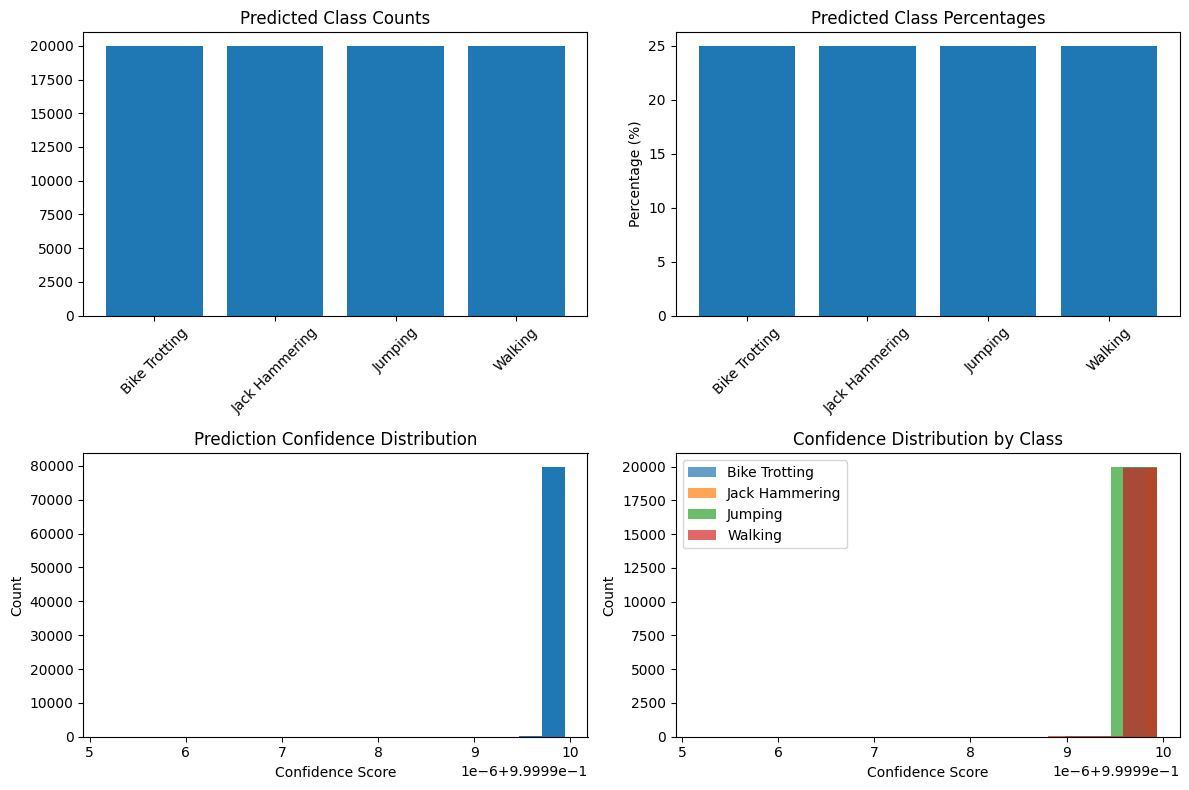

Streaming output truncated to the last 5000 lines.
  Walking: 1.0000

Sample 79167: Predicted Walking with 1.0000 confidence
  Bike Trotting: 0.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 1.0000

Sample 79168: Predicted Walking with 1.0000 confidence
  Bike Trotting: 0.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 1.0000

Sample 79169: Predicted Walking with 1.0000 confidence
  Bike Trotting: 0.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 1.0000

Sample 79170: Predicted Walking with 1.0000 confidence
  Bike Trotting: 0.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 1.0000

Sample 79171: Predicted Walking with 1.0000 confidence
  Bike Trotting: 0.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 1.0000

Sample 79172: Predicted Walking with 1.0000 confidence
  Bike Trotting: 0.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 1.0000

Sample 79173: Predicted Walking with 1.0000 confidence
  Bike Trotting: 0.0000
  Jac

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Path to your saved predictions
# Update this to match your actual output directory
OUTPUT_DIR = "/content/drive/MyDrive/das_prediction_results_80k"
PREDICTIONS_FILE = os.path.join(OUTPUT_DIR, "predictions_80k.npy")

# Class names from your original code
CLASS_NAMES = ["Bike Trotting", "Jack Hammering", "Jumping", "Walking"]

def view_predictions():
    # Load the predictions
    print(f"Loading prediction data from {PREDICTIONS_FILE}")

    try:
        predictions = np.load(PREDICTIONS_FILE)
        print(f"Loaded predictions with shape: {predictions.shape}")

        # Get predicted classes
        predicted_classes = np.argmax(predictions, axis=1)

        # Basic statistics
        print("\nBasic Statistics:")
        print(f"Total predictions: {len(predictions)}")

        # Calculate class distribution
        class_counts = np.bincount(predicted_classes, minlength=len(CLASS_NAMES))
        class_percentages = class_counts / len(predicted_classes) * 100

        print("\nPredicted Class Distribution:")
        for i, name in enumerate(CLASS_NAMES):
            print(f"{name}: {class_counts[i]} samples ({class_percentages[i]:.2f}%)")

        # Plot confidence distribution
        plt.figure(figsize=(12, 8))

        # Plot class distribution
        plt.subplot(2, 2, 1)
        plt.bar(CLASS_NAMES, class_counts)
        plt.title('Predicted Class Counts')
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Plot class distribution percentages
        plt.subplot(2, 2, 2)
        plt.bar(CLASS_NAMES, class_percentages)
        plt.title('Predicted Class Percentages')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=45)

        # Plot confidence histograms
        plt.subplot(2, 2, 3)
        max_confidences = np.max(predictions, axis=1)
        plt.hist(max_confidences, bins=20)
        plt.title('Prediction Confidence Distribution')
        plt.xlabel('Confidence Score')
        plt.ylabel('Count')

        # Plot confidence per class
        plt.subplot(2, 2, 4)
        for i, class_name in enumerate(CLASS_NAMES):
            # Get confidences for this class where it was the predicted class
            class_mask = predicted_classes == i
            if np.any(class_mask):  # Only plot if we have samples for this class
                confidences = predictions[class_mask, i]
                plt.hist(confidences, bins=10, alpha=0.7, label=class_name)

        plt.title('Confidence Distribution by Class')
        plt.xlabel('Confidence Score')
        plt.ylabel('Count')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Sample predictions
        print("\nSample Predictions :")
        for i in range(len(predictions)):
            pred_class = predicted_classes[i]
            confidence = predictions[i, pred_class]
            print(f"Sample {i}: Predicted {CLASS_NAMES[pred_class]} with {confidence:.4f} confidence")
            # Print confidences for all classes
            for j, class_name in enumerate(CLASS_NAMES):
                print(f"  {class_name}: {predictions[i, j]:.4f}")
            print()

        return predictions, predicted_classes

    except Exception as e:
        print(f"Error loading or processing predictions: {e}")
        import traceback
        traceback.print_exc()
        return None, None

if __name__ == "__main__":
    predictions, classes = view_predictions()

In [6]:
# Assuming you have a ground truth file
GROUND_TRUTH_FILE = os.path.join(OUTPUT_DIR, "ground_truth_labels_80k.npy")  # Update with your actual file path

def view_predictions_with_ground_truth():
    try:
        # Load predictions
        predictions = np.load(PREDICTIONS_FILE)
        predicted_classes = np.argmax(predictions, axis=1)

        # Load ground truth
        ground_truth = np.load(GROUND_TRUTH_FILE)

        # Create a DataFrame for comparison
        comparison_data = []
        for i in range(len(predictions)):
            pred_class = predicted_classes[i]
            actual_class = ground_truth[i]

            row_data = {
                'Sample_ID': i,
                'Actual_Class': CLASS_NAMES[actual_class],
                'Predicted_Class': CLASS_NAMES[pred_class],
                'Correct': actual_class == pred_class,
                'Confidence': predictions[i, pred_class]
            }

            # Add confidences for all classes
            for j, class_name in enumerate(CLASS_NAMES):
                row_data[f'{class_name}_Confidence'] = predictions[i, j]

            comparison_data.append(row_data)

        # Create DataFrame and export
        results_df = pd.DataFrame(comparison_data)

        # Calculate accuracy
        accuracy = results_df['Correct'].mean() * 100
        print(f"\nOverall Accuracy: {accuracy:.2f}%")

        # Create confusion matrix
        conf_matrix = pd.crosstab(
            pd.Series([CLASS_NAMES[i] for i in ground_truth], name='Actual'),
            pd.Series([CLASS_NAMES[i] for i in predicted_classes], name='Predicted')
        )
        print("\nConfusion Matrix:")
        print(conf_matrix)

        # Export to CSV and Excel
        csv_path = os.path.join(OUTPUT_DIR, "prediction_comparison.csv")
        results_df.to_csv(csv_path, index=False)
        print(f"Exported comparison to {csv_path}")

        try:
            excel_path = os.path.join(OUTPUT_DIR, "prediction_comparison.xlsx")
            results_df.to_excel(excel_path, index=False)
            print(f"Exported comparison to {excel_path}")
        except Exception as e:
            print(f"Could not export to Excel: {e}")

        return results_df, conf_matrix

    except Exception as e:
        print(f"Error processing comparison: {e}")
        import traceback
        traceback.print_exc()
        return None, None

Loading prediction data from /content/drive/MyDrive/das_prediction_results_80k/predictions_80k.npy
Loaded predictions with shape: (80000, 4)

Basic Statistics:
Total predictions: 80000

Predicted Class Distribution:
Bike Trotting: 20000 samples (25.00%)
Jack Hammering: 20000 samples (25.00%)
Jumping: 20000 samples (25.00%)
Walking: 20000 samples (25.00%)


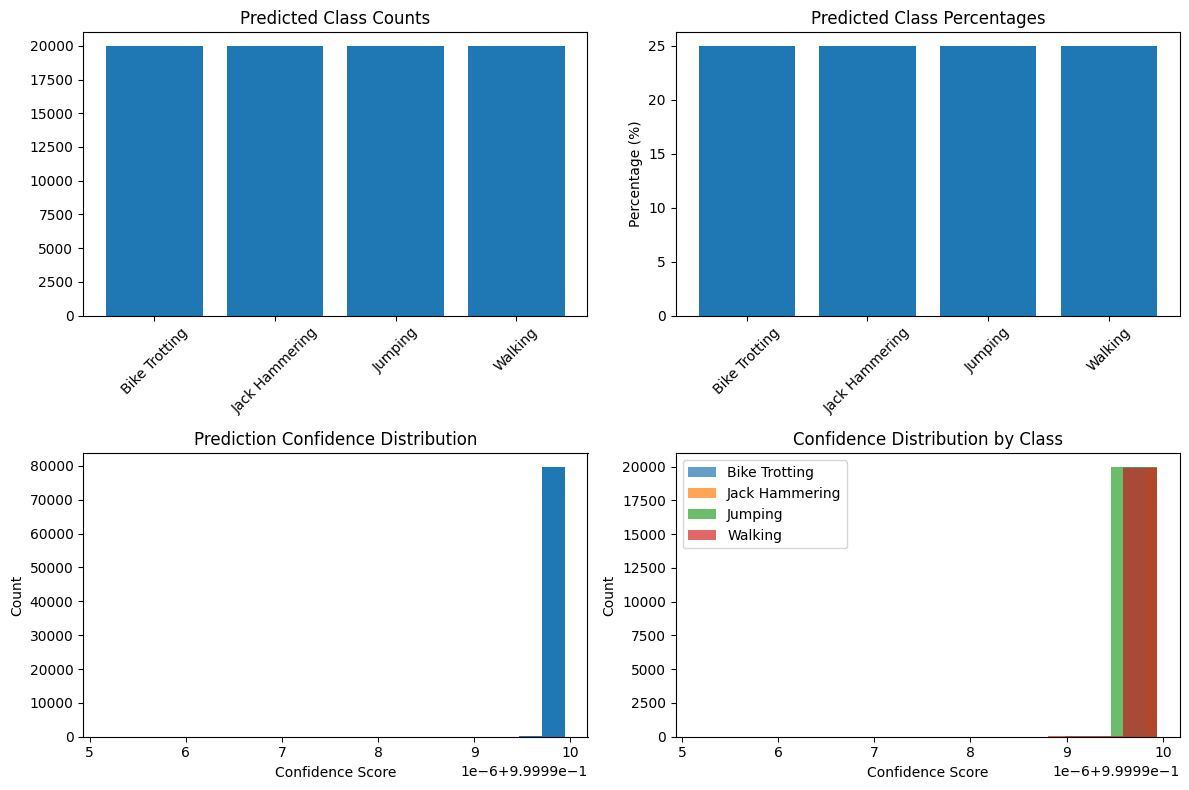


Sample Predictions :
Sample 0: Predicted Bike Trotting with 1.0000 confidence
  Bike Trotting: 1.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 0.0000

Sample 1: Predicted Bike Trotting with 1.0000 confidence
  Bike Trotting: 1.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 0.0000

Sample 2: Predicted Bike Trotting with 1.0000 confidence
  Bike Trotting: 1.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 0.0000

Sample 3: Predicted Bike Trotting with 1.0000 confidence
  Bike Trotting: 1.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 0.0000

Sample 4: Predicted Bike Trotting with 1.0000 confidence
  Bike Trotting: 1.0000
  Jack Hammering: 0.0000
  Jumping: 0.0000
  Walking: 0.0000

Exported results to /content/drive/MyDrive/das_prediction_results_80k/prediction_results.csv
Could not export to Excel: No module named 'openpyxl'

Preview of the exported data:
   Sample_ID Predicted_Class  Confidence  Bike Trotting_Confidence  \
0          0   

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# Path to your saved predictions
OUTPUT_DIR = "/content/drive/MyDrive/das_prediction_results_80k"
PREDICTIONS_FILE = os.path.join(OUTPUT_DIR, "predictions_80k.npy")

# Class names from your original code
CLASS_NAMES = ["Bike Trotting", "Jack Hammering", "Jumping", "Walking"]

def view_predictions():
    # Load the predictions
    print(f"Loading prediction data from {PREDICTIONS_FILE}")

    try:
        predictions = np.load(PREDICTIONS_FILE)
        print(f"Loaded predictions with shape: {predictions.shape}")

        # Get predicted classes
        predicted_classes = np.argmax(predictions, axis=1)

        # Basic statistics
        print("\nBasic Statistics:")
        print(f"Total predictions: {len(predictions)}")

        # Calculate class distribution
        class_counts = np.bincount(predicted_classes, minlength=len(CLASS_NAMES))
        class_percentages = class_counts / len(predicted_classes) * 100

        print("\nPredicted Class Distribution:")
        for i, name in enumerate(CLASS_NAMES):
            print(f"{name}: {class_counts[i]} samples ({class_percentages[i]:.2f}%)")

        # Plot confidence distribution
        plt.figure(figsize=(12, 8))

        # Plot class distribution
        plt.subplot(2, 2, 1)
        plt.bar(CLASS_NAMES, class_counts)
        plt.title('Predicted Class Counts')
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Plot class distribution percentages
        plt.subplot(2, 2, 2)
        plt.bar(CLASS_NAMES, class_percentages)
        plt.title('Predicted Class Percentages')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=45)

        # Plot confidence histograms
        plt.subplot(2, 2, 3)
        max_confidences = np.max(predictions, axis=1)
        plt.hist(max_confidences, bins=20)
        plt.title('Prediction Confidence Distribution')
        plt.xlabel('Confidence Score')
        plt.ylabel('Count')

        # Plot confidence per class
        plt.subplot(2, 2, 4)
        for i, class_name in enumerate(CLASS_NAMES):
            # Get confidences for this class where it was the predicted class
            class_mask = predicted_classes == i
            if np.any(class_mask):  # Only plot if we have samples for this class
                confidences = predictions[class_mask, i]
                plt.hist(confidences, bins=10, alpha=0.7, label=class_name)

        plt.title('Confidence Distribution by Class')
        plt.xlabel('Confidence Score')
        plt.ylabel('Count')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Sample predictions
        print("\nSample Predictions :")
        for i in range(min(5, len(predictions))):  # Just show first 5 for brevity
            pred_class = predicted_classes[i]
            confidence = predictions[i, pred_class]
            print(f"Sample {i}: Predicted {CLASS_NAMES[pred_class]} with {confidence:.4f} confidence")
            # Print confidences for all classes
            for j, class_name in enumerate(CLASS_NAMES):
                print(f"  {class_name}: {predictions[i, j]:.4f}")
            print()

        # Create a DataFrame for export
        export_data = []
        for i in range(len(predictions)):
            pred_class = predicted_classes[i]
            row_data = {
                'Sample_ID': i,
                'Predicted_Class': CLASS_NAMES[pred_class],
                'Confidence': predictions[i, pred_class]
            }
            # Add confidences for all classes
            for j, class_name in enumerate(CLASS_NAMES):
                row_data[f'{class_name}_Confidence'] = predictions[i, j]

            export_data.append(row_data)

        # Create DataFrame and export
        results_df = pd.DataFrame(export_data)

        # Export to CSV
        csv_path = os.path.join(OUTPUT_DIR, "prediction_results.csv")
        results_df.to_csv(csv_path, index=False)
        print(f"Exported results to {csv_path}")

        # Export to Excel (if pandas has openpyxl or xlsxwriter installed)
        try:
            excel_path = os.path.join(OUTPUT_DIR, "prediction_results.xlsx")
            results_df.to_excel(excel_path, index=False)
            print(f"Exported results to {excel_path}")
        except Exception as e:
            print(f"Could not export to Excel: {e}")

        return predictions, predicted_classes, results_df

    except Exception as e:
        print(f"Error loading or processing predictions: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

if __name__ == "__main__":
    predictions, classes, results_df = view_predictions()

    # Display the first few rows of the DataFrame
    if results_df is not None:
        print("\nPreview of the exported data:")
        print(results_df.head())

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/das_prediction_results_80k/prediction_results.csv")
df.head(80000)